# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import warnings
import logging
import pickle
import inspect
import os
import gc
import math

# disabling unnecceseray warnings
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow import keras
from keras import layers
import datetime
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from keras import regularizers
from typing import List
import shutil
import json
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from collections import Counter
import spacy
import re
import lightgbm as lgb
from lightgbm import LGBMRegressor, log_evaluation, early_stopping
from sklearn.metrics import mean_squared_error
import polars as pl
import spacy
import re
import string
import inspect
tqdm.pandas()


keras.mixed_precision.set_global_policy("mixed_float16")

# Limit the GPU memory growth using TensorFlow
# physical_devices = tf.config.list_physical_devices('GPU')
# if len(physical_devices) > 0:
#     tf.config.experimental.set_memory_growth(physical_devices[0], True)
    # tf.config.experimental.set_memory_growth(physical_devices[1], True)

import random
# Set random seeds
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
random.seed(random_seed)
keras.utils.set_random_seed(random_seed)

# !pip install /kaggle/input/autocorrect/autocorrect-2.6.1.tar
# from autocorrect import Speller
# spell = Speller(lang='en', fast=True)

!pip install /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl
from spellchecker import SpellChecker
spellchecker = SpellChecker()

2024-06-20 20:40:20.460240: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-20 20:40:20.460381: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-20 20:40:20.632340: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Processing /kaggle/input/pyspellchecker/pyspellchecker-0.7.2-py3-none-any.whl


# Loading Data

In [2]:
data_path = '/kaggle/input/commonlit-evaluate-student-summaries/'

# prompts train
train_pro = pd.read_csv(data_path + 'prompts_train.csv')
train_pro.head(1)

# summaries train
train_sum = pd.read_csv(data_path + 'summaries_train.csv')
train_sum.head(1)

train = train_pro.merge(train_sum , on = "prompt_id")
train.head(1)

# prompts test
test_pro = pd.read_csv(data_path + 'prompts_test.csv')
test_pro.head(1)

# summaries test
test_sum = pd.read_csv(data_path + 'summaries_test.csv')
test_sum.head(1)
test = test_pro.merge(test_sum , on = "prompt_id")
test.head()

,prompt_id,prompt_question,prompt_title,prompt_text,student_id,text
0,abc123,Summarize...,Example Title 1,Heading\nText...,000000ffffff,Example text 1
1,abc123,Summarize...,Example Title 1,Heading\nText...,222222cccccc,Example text 3
2,def789,Summarize...,Example Title 2,Heading\nText...,111111eeeeee,Example text 2
3,def789,Summarize...,Example Title 2,Heading\nText...,333333dddddd,Example text 4


# Preprocessing (Full Model)

In [3]:
prefix1 = "Think through this step by step: "
prefix2 = "Pay attention to the content and wording: "
MAX_SUMMARY_LENGTH = 1500 + len(prefix1) + len(prefix2)

def preprocess(summary, prompt_question, prompt_text, tokenizer):
    
    sep = f" {tokenizer.sep_token} " 
    summary = prefix1 + prompt_question + sep + prefix2 + summary + sep + prompt_text
    tokenized = tokenizer.batch_encode_plus(summary.tolist(),
                                              add_special_tokens=False,
                                              truncation=True,
                                              padding='max_length',
                                              return_tensors='tf',
                                              max_length=MAX_SUMMARY_LENGTH,
                                              return_attention_mask=True)
    
    input_ids = tokenized['input_ids']
    attention_mask = tokenized['attention_mask']

    # Create head mask
    head_mask = np.zeros(input_ids.shape)
    for i, summ in enumerate(input_ids.numpy()):
        use_full = False
        for j, token in enumerate(summ):
            if token == tokenizer.sep_token_id:
                use_full = not use_full  
            head_mask[i][j] = (1. if use_full else 0.) 
    head_mask = tf.constant(head_mask)
    
    return input_ids, attention_mask, head_mask

def build_dataset(summaries, prompt_questions, prompt_texts, tokenizer):    
    # Tokenization
    input_ids, attention_mask, head_mask = preprocess(summaries, prompt_questions, prompt_texts, tokenizer)
    return [input_ids.numpy(), attention_mask.numpy(), head_mask.numpy()]

In [4]:
# # Check head mask of first prompt (for debug)


# ids, mask, head = build_dataset(train['text'], train['prompt_question'], train['prompt_text'])
# train['input'] = prefix1 + train['prompt_question'] + sep + prefix2 + train['text'] + sep + train['prompt_text']
# first = tokenizer.tokenize(train['input'][0],                                               
#           add_special_tokens=False,
#           truncation=True,
#           padding='max_length',
#           return_tensors='tf',
#           max_length=MAX_SUMMARY_LENGTH,
#           return_attention_mask=False)

# def find_indexes(array):
#     return [index for index, value in enumerate(array) if value == 1]
# np.array(first)[find_indexes(head[0])]

# Define Full Model

In [4]:
# build our NN on top of Deberta

# Create a layer that wraps the pre trained model to support Keras library
class PreTrainedModel(keras.Model):
    def __init__(self, model_path, trainable=False, num_layers_to_freeze=8, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.model = TFAutoModel.from_pretrained(model_path + "model") 
        self.tokenizer = AutoTokenizer.from_pretrained(model_path + "tokenizer")
        self.trainable = trainable
        self.num_layers_to_freeze = num_layers_to_freeze
        
        # define model configurations
        self.model.trainable = self.trainable
        self.model.config.hidden_dropout_prob = 0.0
        self.model.config.attention_probs_dropout_prob = 0.0
        
        # freeze layers if trainable
        if self.trainable:
            self.model.trainable = self.trainable
            if self.trainable:
                for layer in self.model.layers[0].encoder.layer[:self.num_layers_to_freeze]:
                    layer.trainable = False

        # Dynamically create properties from pre-trained model
        # for prop_name, prop in inspect.getmembers(self.model):
        #    if not prop_name.startswith('_') and not inspect.ismethod(prop):
        #        setattr(self.__class__, prop_name, prop)

    def call(self, input_ids, attention_mask):
        # Call the pre trained model and get the last hidden state
        output = self.model(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
        return output.hidden_states

In [5]:
# The loss function
def mcrmse(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float16)
    y_pred = tf.cast(y_pred, tf.float16)
    columnwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
    return tf.reduce_mean(tf.sqrt(columnwise_mse), axis=-1)

In [6]:
# HyperParameters
init_lr = 0.00015
batch_size = 4
epochs = 4

In [ ]:
def create_model(decay_steps=10000, warmup_steps=100, input_shape=(1575,), embeddings_len=1024):
    
    # Instances
    model_path = '/kaggle/input/deberta-v3-large/deberta_v3_large/'
    pre_trained_model_instance = PreTrainedModel(model_path, name="deberta_layer")
    expand_dims_instance = layers.Lambda(lambda x: tf.expand_dims(tf.cast(x, dtype=tf.float32), axis=-1), name=f'expand_dims')
    mask_instance = layers.Lambda(lambda x: tf.multiply(x[0], x[1]), output_shape=(1575, embeddings_len,), name='masked_embeddings')
    avg_pooling_instance = layers.GlobalAveragePooling1D()
    reshape_instance1 = layers.Reshape((1, -1), name='reshape_layer1')
#     reshape_instance2 = layers.Reshape((1, -1), name='reshape_layer2')
#     dense_instance = layers.Dense(embeddings_len, activation='gelu')
#     avg_pooling_instance2 = layers.GlobalAveragePooling1D()
    dropout_instance = layers.Dropout(0.3)
    

    # The NN starts from here
    
    # Input layers
    input_ids = keras.Input(shape=input_shape, dtype='int32', name='input_ids')
    attention_mask = keras.Input(shape=input_shape, dtype='int32', name='attention_mask')
    head_mask = keras.Input(shape=input_shape, dtype='float32', name='head_mask')
    
    # Create embeddings and get all hidden states
    deberta = pre_trained_model_instance(input_ids, attention_mask)
    
    # Mask pooling all hidden states of pre-trained model
    pooled_hidden_states = []
    num_hidden_layers = 4
    for layer in deberta[-num_hidden_layers:]:
        h_mask = expand_dims_instance(head_mask)
        masked_outputs = mask_instance([dropout_instance(layer), h_mask])
        avg_pooling_layer = avg_pooling_instance(masked_outputs)
        reshape_layer = reshape_instance1(avg_pooling_layer)
        pooled_hidden_states.append(reshape_layer)
    
    # Concatenate all the hidden states an forward pass through LSTM
    x = layers.Concatenate(axis=1)(pooled_hidden_states)
    x = layers.LSTM(embeddings_len, return_sequences=False)(x)
    x = layers.Dense(512, activation='linear')(x)
    x = layers.LayerNormalization()(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Activation(keras.activations.gelu, name='gelu')(x)
    
    output_layer = layers.Dense(2, activation='linear')(x)
    
    # Multi-sample Dropout
#     x = layers.Dropout(0.3)(x)
#     dropoutList = [reshape_instance2(avg_pooling_instance2(dense_instance(layers.Dropout((i + 1) * 0.1)(x)))) for i in range(5)]
#     x = layers.Concatenate(axis=1)(dropoutList)
#     x = layers.GlobalAveragePooling1D()(x)

    model = keras.Model(inputs=[input_ids, attention_mask, head_mask], outputs=output_layer)
    lr_schedule = tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=init_lr,
                                                            decay_steps=decay_steps,
                                                            warmup_target=init_lr,
                                                            warmup_steps=warmup_steps,
                                                           )
    opt = keras.optimizers.AdamW(learning_rate=lr_schedule)
    model.compile(loss=mcrmse, optimizer=opt)
    return model, pre_trained_model_instance

# model, deberta_model = create_model()
# model.summary()
# model.load_weights("/kaggle/input/no-aug-model-weights/no_augmentation_model.weights.h5")
# deberta_model.summary()

# Train Full Model

In [8]:
# Choose Training type
train_with_folds = True

In [ ]:
X = train[['text', 'prompt_question', 'prompt_text']]
y = train[['content', 'wording']].astype('float16')

if train_with_folds:
    
    # Train full model with GroupKFolds
    gkf = GroupKFold(n_splits=4)
    folds = gkf.split(X, y, groups=train['prompt_id'])

    val_losses = []
    histories = []

    for i, (train_index, val_index) in enumerate(folds):
        print(f"Fold {i}")
        
        if i != 3:
             continue

        X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
        y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

        decay_steps = math.ceil((len(X_train_fold) / batch_size) * epochs) 
        model, deberta = create_model(decay_steps=decay_steps)

        X_train_fold = build_dataset(X_train_fold['text'], X_train_fold['prompt_question'], X_train_fold['prompt_text'], deberta.tokenizer)
        X_val_fold = build_dataset(X_val_fold['text'], X_val_fold['prompt_question'], X_val_fold['prompt_text'], deberta.tokenizer)


        early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
#         ema = keras.callbacks.SwapEMAWeights(swap_on_epoch=True)

        # Checkpoint callback
        ckptcb = keras.callbacks.ModelCheckpoint(
            f"full_model_fold_{i}" + ".weights.h5",
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            mode="min",
        ) 

        history = model.fit(x=X_train_fold,
                            y=y_train_fold.values,
                            validation_data=(X_val_fold, y_val_fold.values),
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[early_stopping, ckptcb],
                            verbose=1)

        # Get the validation loss from the last epoch
        val_loss = min(history.history['val_loss'])
        val_losses.append(val_loss)
        histories.append(history)
        print()

    # Calculate the mean validation loss
    mean_val_loss = np.mean(val_losses)
    print("Mean Validation Loss:", mean_val_loss)
    
    
else:
    # Train full model no folds all data
    decay_steps = math.ceil((len(X) / batch_size) * epochs) 
    model, deberta = create_model(decay_steps=decay_steps)
    
    X = build_dataset(X['text'], X['prompt_question'], X['prompt_text'], deberta.tokenizer)
    
    # Callbacks
    early_stopping = EarlyStopping(monitor='loss', patience=2, restore_best_weights=True)
#     ema = keras.callbacks.SwapEMAWeights(swap_on_epoch=True)
    ckptcb = keras.callbacks.ModelCheckpoint(
        "no_augment_full_model" + ".weights.h5",
        monitor="loss",
        save_best_only=True,
        save_weights_only=True,
        mode="min",
    )    
    
    history = model.fit(x=X,
                        y=y.values,
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, ckptcb],
                        verbose=1)
print('done')

# Meta Psuedo Labels Training loop

In [ ]:
# # loading augmented data
# augmented_data = pd.read_excel('/kaggle/input/llm-generate-test/LLM_Generate_Test.xlsx')
# augmented_data.columns = ['student_id', 'prompt_text', 'prompt_question', 'text']

# augmented_data["text"] = augmented_data["text"].apply(lambda x: spell(x))
# augmented_data['input'] = prefix1 + augmented_data['prompt_question'] + sep + prefix2 + augmented_data['text']

In [17]:
def generate_predictions(model, data):
    contents = []
    wordings = []
    ids = []
    predictions = model.predict(x=[data['input_ids'], data['attention_mask'], data['head_mask']],
                                batch_size=4)

    for idx, output in enumerate(predictions):
        contents.append(output[0])
        wordings.append(output[1])
        ids.append(data['student_id'][idx])
    return ids, contents, wordings

In [11]:
# # Tokenizing augmented data
# tokenized_summaries_aug = tokenizer.batch_encode_plus(augmented_data['input'].tolist(),
#                                               add_special_tokens=True,
#                                               truncation=True,
#                                               padding='max_length',
#                                               return_tensors='tf',
#                                               max_length=MAX_SUMMARY_LENGTH,
#                                               return_attention_mask = True)
# del tokenized_summaries_aug['token_type_ids']

# # Create head mask that excludes anything but sep + prefix2 + train['text']
# head_mask_aug = np.zeros(tokenized_summaries_aug['input_ids'].shape)
# for i, summary in enumerate(tokenized_summaries_aug['input_ids'].numpy()):
#     use_full = False
#     for j, token in enumerate(summary):
#         if token == tokenizer.sep_token_id:
#             use_full = not use_full
#         head_mask_aug[i][j] = (1 if use_full else 0) 
# head_mask_aug = tf.constant(head_mask_aug)

# aug_input = {
#     'input_ids': tokenized_summaries_aug['input_ids'],
#     'attention_mask': tokenized_summaries_aug['attention_mask'],
#     'head_mask': head_mask_aug,
#     'student_id': augmented_data['student_id']
# }

In [16]:
# ROUNDS = 3
# SAVED_DATASETS_INDEXES = [0, 1, 2]
# SAVED_WEIGHTS_INDEXES = [0, 1, 2]

# # the initial model
# model, _ = create_model()

# if SAVED_WEIGHTS_INDEXES[-1] == 0:
#     model.load_weights('/kaggle/input/no-aug-model-weights/no_augmentation_model.weights.h5')
# else:
#     print(f"Loading weights: meta_model_{SAVED_WEIGHTS_INDEXES[-1]}")
#     model.load_weights(f'/kaggle/input/meta-model-weights/meta_model_{SAVED_WEIGHTS_INDEXES[-1]}.weights.h5')

# Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)
# Y_train = Y_train.numpy()

# for i in range(ROUNDS):
            
#     print(f"Round {i + 1}/{ROUNDS}")
    
#     if i < SAVED_WEIGHTS_INDEXES[-1]:
#         continue
    
#     # predict meta psuedo labels
    
#     if i in SAVED_DATASETS_INDEXES:
#         # predictions already generated
#         if i == 0:
#             augmented_labeled_data = pd.read_csv('/kaggle/input/augmented-labeled-data/augmented_labeled_data.csv')
#         else:
#             augmented_labeled_data = pd.read_csv(f'/kaggle/input/augmented-labeled-data/augmented_labeled_data_round_{i + 1}.csv')
#     else:
#         print()
#         print(f"Generateing predictions...")
#         ids, contents, wordings = generate_predictions(model, aug_input)
#         augmented_data['content'] = contents
#         augmented_data['wording'] = wordings
#         augmented_data.to_csv(f"augmented_labeled_data_round_{i + 1}.csv")
#         augmented_labeled_data = augmented_data
        
#     # update the labels    
#     Y_train_aug = tf.constant(augmented_labeled_data[['content', 'wording']].values, dtype=tf.float32)
#     Y_train_aug = Y_train_aug.numpy()

#     # checkpoint callback
#     ckptcb = keras.callbacks.ModelCheckpoint(
#         f"meta_model_{i + 1}" + ".weights.h5",
#         monitor="loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#     )
    
#     print()
#     print(f"Training on unlabeled data...")
#     model.fit(x=[tokenized_summaries_aug['input_ids'], tokenized_summaries_aug['attention_mask'], head_mask_aug],
#                       y=Y_train_aug,
#                       epochs=2,
#                       batch_size=4,
#                       validation_data=([tokenized_summaries['input_ids'], tokenized_summaries['attention_mask'], head_mask], Y_train),
#                       verbose=1)
    
#     # Fine tune the pre-trained model only on the labeled data
#     print()
#     print(f"Training on labeled data...")
#     model.fit(x=[tokenized_summaries['input_ids'], tokenized_summaries['attention_mask'], head_mask],
#                       y=Y_train,
#                       epochs=3,
#                       batch_size=4,
#                       callbacks=[ckptcb],
#                       verbose=1)
#     print()

Loading weights: meta_model_1
Round 1/3
Round 2/3

Generateing predictions...
   1/5000 ━━━━━━━━━━━━━━━━━━━━ 48:40:10 35s/step

I0000 00:00:1717797400.180685     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717797400.232535     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5529s 1s/step

Training on unlabeled data...
Epoch 1/2


W0000 00:00:1717802965.185144     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 0.1885

W0000 00:00:1717808521.972703     117 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717810520.321222     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7620s 2s/step - loss: 0.1885 - val_loss: 0.4478
Epoch 2/2
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7500s 2s/step - loss: 0.1660 - val_loss: 0.4378

Training on labeled data...
Epoch 1/3


W0000 00:00:1717818085.708646     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1791/1792 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4596

W0000 00:00:1717820098.837005     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1792/1792 ━━━━━━━━━━━━━━━━━━━━ 2078s 1s/step - loss: 0.4596
Epoch 2/3
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 1982s 1s/step - loss: 0.4573
Epoch 3/3
1792/1792 ━━━━━━━━━━━━━━━━━━━━ 1982s 1s/step - loss: 0.4561

Round 3/3

Generateing predictions...
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 5494s 1s/step

Training on unlabeled data...
Epoch 1/2
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 7502s 2s/step - loss: 0.1541 - val_loss: 0.4378
Epoch 2/2
 480/5000 ━━━━━━━━━━━━━━━━━━━━ 1:23:14 1s/step - loss: 0.1568


KeyboardInterrupt



# LGBM Model

## Preprocessing + Feature Engineering

In [3]:
DATA_DIR = "/kaggle/input/commonlit-evaluate-student-summaries/"

prompts_train = pd.read_csv(DATA_DIR + "prompts_train.csv")
prompts_test = pd.read_csv(DATA_DIR + "prompts_test.csv")
summaries_train = pd.read_csv(DATA_DIR + "summaries_train.csv")
summaries_test = pd.read_csv(DATA_DIR + "summaries_test.csv")
sample_submission = pd.read_csv(DATA_DIR + "sample_submission.csv")

In [4]:
class Preprocessor:
    def __init__(self, model_name: str,) -> None:
        self.STOP_WORDS = set(stopwords.words('english'))

        self.tokenizer = AutoTokenizer.from_pretrained(model_name + "tokenizer")
        self.spacy_ner_model = spacy.load('en_core_web_sm',)
        self.speller = SpellChecker() #Speller(lang='en')
        
    def count_text_length(self, df: pd.DataFrame, col:str) -> pd.Series:
        """ text length """
        tokenizer=self.tokenizer
        return df[col].progress_apply(lambda x: len(tokenizer.encode(x)))

    def word_overlap_count(self, row):
        """ intersection(prompt_text, text) """        
        def check_is_stop_word(word):
            return word in self.STOP_WORDS
        
        prompt_words = row['prompt_tokens']
        summary_words = row['summary_tokens']
        if self.STOP_WORDS:
            prompt_words = list(filter(check_is_stop_word, prompt_words))
            summary_words = list(filter(check_is_stop_word, summary_words))
        return len(set(prompt_words).intersection(set(summary_words)))
            
    def ngrams(self, token, n):
        # Use the zip function to help us generate n-grams
        # Concatentate the tokens into ngrams and return
        ngrams = zip(*[token[i:] for i in range(n)])
        return [" ".join(ngram) for ngram in ngrams]

    def ngram_co_occurrence(self, row, n: int):
        # Tokenize the original text and summary into words
        original_tokens = row['prompt_tokens']
        summary_tokens = row['summary_tokens']

        # Generate n-grams for the original text and summary
        original_ngrams = set(self.ngrams(original_tokens, n))
        summary_ngrams = set(self.ngrams(summary_tokens, n))

        # Calculate the number of common n-grams
        common_ngrams = original_ngrams.intersection(summary_ngrams)

        # # Optionally, you can get the frequency of common n-grams for a more nuanced analysis
        # original_ngram_freq = Counter(ngrams(original_words, n))
        # summary_ngram_freq = Counter(ngrams(summary_words, n))
        # common_ngram_freq = {ngram: min(original_ngram_freq[ngram], summary_ngram_freq[ngram]) for ngram in common_ngrams}

        return len(common_ngrams)
    
    def ner_overlap_count(self, row, mode:str):
        model = self.spacy_ner_model
        def clean_ners(ner_list):
            return set([(ner[0].lower(), ner[1]) for ner in ner_list])
        prompt = model(row['prompt_text'])
        summary = model(row['text'])

        if "spacy" in str(model):
            prompt_ner = set([(token.text, token.label_) for token in prompt.ents])
            summary_ner = set([(token.text, token.label_) for token in summary.ents])
        elif "stanza" in str(model):
            prompt_ner = set([(token.text, token.type) for token in prompt.ents])
            summary_ner = set([(token.text, token.type) for token in summary.ents])
        else:
            raise Exception("Model not supported")

        prompt_ner = clean_ners(prompt_ner)
        summary_ner = clean_ners(summary_ner)

        intersecting_ners = prompt_ner.intersection(summary_ner)
        
        ner_dict = dict(Counter([ner[1] for ner in intersecting_ners]))
        
        if mode == "train":
            return ner_dict
        elif mode == "test":
            return {key: ner_dict.get(key) for key in self.ner_keys}

    
    def quotes_count(self, row):
        summary = row['text']
        text = row['prompt_text']
        quotes_from_summary = re.findall(r'"([^"]*)"', summary)
        if len(quotes_from_summary)>0:
            return [quote in text for quote in quotes_from_summary].count(True)
        else:
            return 0

    def spelling(self, text):
        
        wordlist=text.split()
        amount_miss = len(list(self.speller.unknown(wordlist)))

        return amount_miss
    
    def run(self, 
            prompts: pd.DataFrame,
            summaries:pd.DataFrame,
            mode:str
        ) -> pd.DataFrame:
        
        # before merge preprocess
        prompts["prompt_length"] = prompts["prompt_text"].apply(
            lambda x: len(self.tokenizer.encode(x))
        )
        prompts["prompt_tokens"] = prompts["prompt_text"].apply(
            lambda x: self.tokenizer.convert_ids_to_tokens(
                self.tokenizer.encode(x), 
                skip_special_tokens=True
            )
        )

        summaries["summary_length"] = summaries["text"].apply(
            lambda x: len(self.tokenizer.encode(x))
        )
        summaries["summary_tokens"] = summaries["text"].apply(
            lambda x: self.tokenizer.convert_ids_to_tokens(
                self.tokenizer.encode(x), 
                skip_special_tokens=True
            )

        )
        summaries["splling_err_num"] = summaries["text"].progress_apply(self.spelling)

        # merge prompts and summaries
        input_df = summaries.merge(prompts, how="left", on="prompt_id")

        # after merge preprocess
        input_df['length_ratio'] = input_df['summary_length'] / input_df['prompt_length']
        
        input_df['word_overlap_count'] = input_df.progress_apply(self.word_overlap_count, axis=1)
        input_df['bigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence,args=(2,), axis=1 
        )
        input_df['trigram_overlap_count'] = input_df.progress_apply(
            self.ngram_co_occurrence, args=(3,), axis=1
        )
        
        input_df['quotes_count'] = input_df.progress_apply(self.quotes_count, axis=1)
        
        return input_df.drop(columns=["summary_tokens", "prompt_tokens"])

In [5]:
model_path = '/kaggle/input/deberta-v3-large/deberta_v3_large/'
preprocessor = Preprocessor(model_name=model_path)

features_train = preprocessor.run(prompts_train, summaries_train, mode="train")
features_test = preprocessor.run(prompts_test, summaries_test, mode="test")
features_test['length'] = features_test['summary_length'] + features_test['prompt_length']
features_test = features_test.sort_values('length', ascending=True).reset_index(drop=True)
features_train.head()

100%|██████████| 4/4 [00:00<00:00, 4908.49it/s]


,student_id,prompt_id,text,content,wording,summary_length,splling_err_num,prompt_question,prompt_title,prompt_text,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,trigram_overlap_count,quotes_count
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,69,5,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.102832,0,5,0,0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,56,2,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",1137,0.049252,0,22,10,0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,285,32,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.437788,1,56,26,2
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,43,5,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,651,0.066052,1,10,6,0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,253,29,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,671,0.377049,1,27,5,4


## More Feature Engineering (6000+ features)

In [6]:
data_path = '/kaggle/input/commonlit-evaluate-student-summaries/'
# prompts train
train_pro_polars = pl.read_csv(data_path + 'prompts_train.csv')
train_pro_polars.head(1)

# summaries train
train_sum_polars = pl.read_csv(data_path + 'summaries_train.csv')
train_sum_polars.head(1)

train_polars = train_pro_polars.join(train_sum_polars , on="prompt_id", how='inner')
train_polars.head(1)

# prompts train
test_pro_polars = pl.read_csv(data_path + 'prompts_test.csv')
test_pro_polars.head(1)

# summaries train
test_sum_polars = pl.read_csv(data_path + 'summaries_test.csv')
test_sum_polars.head(1)

test_polars = test_pro_polars.join(test_sum_polars , on="prompt_id", how='inner')
test_polars.head(1)

columns = [  
    (
        pl.col("text").str.split(by="\n\n").alias("paragraph")
    ),
]
# Load training and testing sets, while using \ n \ n character segmentation to list and renaming to paragraph for text data
train_polars = train_polars.with_columns(columns)
test_polars = test_polars.with_columns(columns)
# train_polars.head(1)

In [7]:
nlp = spacy.load("en_core_web_sm")
with open('/kaggle/input/english-word-hx/words.txt', 'r') as file:
    english_vocab = set(word.strip().lower() for word in file)

In [8]:
# Feature Engineering

paragraph_fea = ['paragraph_len','paragraph_sentence_cnt','paragraph_word_cnt']
paragraph_fea2 = ['paragraph_error_num'] + paragraph_fea
sentence_fea = ['sentence_len','sentence_word_cnt']

def count_spelling_errors(text):
    doc = nlp(text)
    lemmatized_tokens = [token.lemma_.lower() for token in doc]
    spelling_errors = sum(1 for token in lemmatized_tokens if token not in english_vocab)
    return spelling_errors

def removeHTML(x):
    html=re.compile(r'<.*?>')
    return html.sub(r'',x)

def dataPreprocessing(x):
    # Convert words to lowercase
    x = x.lower()
    # Remove HTML
    x = removeHTML(x)
    # Delete strings starting with @
    x = re.sub("@\w+", '',x)
    # Delete Numbers
    x = re.sub("'\d+", '',x)
    x = re.sub("\d+", '',x)
    # Delete URL
    x = re.sub("http\w+", '',x)
    # Replace consecutive empty spaces with a single space character
    x = re.sub(r"\s+", " ", x)
    # Replace consecutive commas and periods with one comma and period character
    x = re.sub(r"\.+", ".", x)
    x = re.sub(r"\,+", ",", x)
    # Remove empty characters at the beginning and end
    x = x.strip()
    return x


# paragraph features
def remove_punctuation(text):
    """
    Remove all punctuation from the input text.
    
    Args:
    - text (str): The input text.
    
    Returns:
    - str: The text with punctuation removed.
    """
    # string.punctuation
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def Paragraph_Preprocess(tmp):
    # Expand the paragraph list into several lines of data
    tmp = tmp.explode('paragraph')
    # Paragraph preprocessing
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(dataPreprocessing))
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(remove_punctuation).alias('paragraph_no_pinctuation'))
    tmp = tmp.with_columns(pl.col('paragraph_no_pinctuation').map_elements(count_spelling_errors).alias("paragraph_error_num"))
    # Calculate the length of each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x)).alias("paragraph_len"))
    # Calculate the number of sentences and words in each paragraph
    tmp = tmp.with_columns(pl.col('paragraph').map_elements(lambda x: len(x.split('.'))).alias("paragraph_sentence_cnt"),
                    pl.col('paragraph').map_elements(lambda x: len(x.split(' '))).alias("paragraph_word_cnt"),)
    return tmp

def Paragraph_Eng(train_tmp):
    num_list = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600]
    num_list2 = [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700]
    aggs = [
        # Count the number of paragraph lengths greater than and less than the i-value
        *[pl.col('paragraph').filter(pl.col('paragraph_len') >= i).count().alias(f"paragraph_{i}_cnt") for i in [0, 50,75,100,125,150,175,200,250,300,350,400,500,600,700] ], 
        *[pl.col('paragraph').filter(pl.col('paragraph_len') <= i).count().alias(f"paragraph_{i}_cnt") for i in [25,49]], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in paragraph_fea2],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in paragraph_fea2],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in paragraph_fea2],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in paragraph_fea2],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in paragraph_fea2],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in paragraph_fea2],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in paragraph_fea2],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in paragraph_fea2],  
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in paragraph_fea2],  
        ]
    
    df = train_tmp.group_by(['student_id'], maintain_order=True).agg(aggs).sort("student_id")
    df = df.to_pandas()
    return df

# sentence feature
def Sentence_Preprocess(tmp):
    # Preprocess text and use periods to segment sentences in the text
    tmp = tmp.with_columns(pl.col('text').map_elements(dataPreprocessing).str.split(by=".").alias("sentence"))
    tmp = tmp.explode('sentence')
    # Calculate the length of a sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x)).alias("sentence_len"))
    # Filter out the portion of data with a sentence length greater than 15
    tmp = tmp.filter(pl.col('sentence_len')>=15)
    # Count the number of words in each sentence
    tmp = tmp.with_columns(pl.col('sentence').map_elements(lambda x: len(x.split(' '))).alias("sentence_word_cnt"))
    
    return tmp


# feature_eng
def Sentence_Eng(train_tmp):
    aggs = [
        # Count the number of sentences with a length greater than i
        *[pl.col('sentence').filter(pl.col('sentence_len') >= i).count().alias(f"sentence_{i}_cnt") for i in [0,15,50,100,150,200,250,300] ], 
        *[pl.col('sentence').filter(pl.col('sentence_len') <= i).count().alias(f"sentence_<{i}_cnt") for i in [15,50] ], 
        # other
        *[pl.col(fea).max().alias(f"{fea}_max") for fea in sentence_fea],
        *[pl.col(fea).mean().alias(f"{fea}_mean") for fea in sentence_fea],
        *[pl.col(fea).min().alias(f"{fea}_min") for fea in sentence_fea],
        *[pl.col(fea).sum().alias(f"{fea}_sum") for fea in sentence_fea],
        *[pl.col(fea).first().alias(f"{fea}_first") for fea in sentence_fea],
        *[pl.col(fea).last().alias(f"{fea}_last") for fea in sentence_fea],
        *[pl.col(fea).kurtosis().alias(f"{fea}_kurtosis") for fea in sentence_fea],
        *[pl.col(fea).quantile(0.25).alias(f"{fea}_q1") for fea in sentence_fea], 
        *[pl.col(fea).quantile(0.75).alias(f"{fea}_q3") for fea in sentence_fea], 
        ]
    df = train_tmp.group_by(['student_id'], maintain_order=True).agg(aggs).sort("student_id")
    df = df.to_pandas()
    return df

# word feature
def Word_Preprocess(tmp):
    # Preprocess text and use spaces to separate words from the text
    tmp = tmp.with_columns(pl.col('text').map_elements(dataPreprocessing).str.split(by=" ").alias("word"))
    tmp = tmp.explode('word')
    # Calculate the length of each word
    tmp = tmp.with_columns(pl.col('word').map_elements(lambda x: len(x)).alias("word_len"))
    # Delete data with a word length of 0
    tmp = tmp.filter(pl.col('word_len')!=0)
    
    return tmp


# feature_eng
def Word_Eng(train_tmp):
    aggs = [
        # Count the number of words with a length greater than i+1
        *[pl.col('word').filter(pl.col('word_len') >= i+1).count().alias(f"word_{i+1}_cnt") for i in range(15) ], 
        # other
        pl.col('word_len').max().alias(f"word_len_max"),
        pl.col('word_len').mean().alias(f"word_len_mean"),
        pl.col('word_len').std().alias(f"word_len_std"),
        pl.col('word_len').quantile(0.25).alias(f"word_len_q1"),
        pl.col('word_len').quantile(0.50).alias(f"word_len_q2"),
        pl.col('word_len').quantile(0.75).alias(f"word_len_q3"),
        ]
    df = train_tmp.group_by(['student_id'], maintain_order=True).agg(aggs).sort("student_id")
    df = df.to_pandas()
    return df

In [9]:
# The preprocessing and feature engineering main function

def preprocess_data(data, fold_indexes=None, vectorizer=None, vectorizer_cnt=None):
    
    tmp = Paragraph_Preprocess(data)
    train_feats = Paragraph_Eng(tmp)
    
    # Obtain feature names
    feature_names = list(filter(lambda x: x not in ['student_id','content', 'wording'], train_feats.columns))
    print('Features Number: ',len(feature_names))
    
    # Sentence features
    tmp = Sentence_Preprocess(data)
    # Merge the newly generated feature data with the previously generated feature data
    train_feats = train_feats.merge(Sentence_Eng(tmp), on='student_id', how='left')

    feature_names = list(filter(lambda x: x not in ['student_id','content', 'wording'], train_feats.columns))
    print('Features Number: ',len(feature_names))
    
    # Word features
    tmp = Word_Preprocess(data)
    # Merge the newly generated feature data with the previously generated feature data
    train_feats = train_feats.merge(Word_Eng(tmp), on='student_id', how='left')

    feature_names = list(filter(lambda x: x not in ['student_id', 'content', 'wording'], train_feats.columns))
    print('Features Number: ',len(feature_names))
    
    # TfidfVectorizer parameter
    if vectorizer == None:
        vectorizer = TfidfVectorizer(
                    tokenizer=lambda x: x,
                    preprocessor=lambda x: x,
                    token_pattern=None,
                    strip_accents='unicode',
                    analyzer = 'word',
                    ngram_range=(3,6),
                    min_df=0.05,
                    max_df=0.95,
                    sublinear_tf=True,
        )

        # Fit all datasets into TfidfVector,this may cause leakage and overly optimistic CV scores
        train_tfid = vectorizer.fit_transform([i for i in data['text']])
    else:
        train_tfid = vectorizer.transform([i for i in data['text']])
        
    # Convert to array
    dense_matrix = train_tfid.toarray()
    # Convert to dataframe
    df = pd.DataFrame(dense_matrix)
    # rename features
    tfid_columns = [ f'tfid_{i}' for i in range(len(df.columns))]
    df.columns = tfid_columns
    df['student_id'] = train_feats['student_id']
    # Merge the newly generated feature data with the previously generated feature data
    train_feats = train_feats.merge(df, on='student_id', how='left')

    feature_names = list(filter(lambda x: x not in ['student_id','content', 'wording'], train_feats.columns))
    print('Features Number: ',len(feature_names))
    
    if vectorizer_cnt == None:
        
        vectorizer_cnt = CountVectorizer(
                tokenizer=lambda x: x,
                preprocessor=lambda x: x,
                token_pattern=None,
                strip_accents='unicode',
                analyzer = 'word',
                ngram_range=(2,3),
                min_df=0.10,
                max_df=0.85,
        )

        train_tfid = vectorizer_cnt.fit_transform([i for i in data['text']])
    else:
        train_tfid = vectorizer_cnt.transform([i for i in data['text']])
        
    dense_matrix = train_tfid.toarray()
    df = pd.DataFrame(dense_matrix)
    tfid_columns = [ f'tfid_cnt_{i}' for i in range(len(df.columns))]
    df.columns = tfid_columns
    df['student_id'] = train_feats['student_id']
    train_feats = train_feats.merge(df, on='student_id', how='left')

    feature_names = list(filter(lambda x: x not in ['student_id','content', 'wording'], train_feats.columns))
    print('Features Number: ',len(feature_names))
    
    # DeBERTa model predictions as features
    # TODO
    # deberta_oof = joblib.load('/kaggle/input/model_predictions.pkl')
    # print(deberta_oof.shape, train_feats.shape)

    # train_feats['deberta_oof'] = deberta_oof

    # feature_names = list(filter(lambda x: x not in ['student_id','content', 'wording'], train_feats.columns))
    # print('Features Number: ', len(feature_names))   

    # merge features 
    if fold_indexes is not None:
        ft = features_train.iloc[fold_indexes].drop(columns=train.columns)
        train_feats_pandas = pd.DataFrame(train_feats.to_numpy(), columns=train_feats.columns, index=fold_indexes)
    else:
        ft = features_train.drop(columns=train.columns)
        train_feats_pandas = pd.DataFrame(train_feats.to_numpy(), columns=train_feats.columns)
    lgbm_input = pd.concat([train_feats_pandas, ft], axis=1)
    
    feature_names = list(filter(lambda x: x not in ['student_id','content', 'wording'], lgbm_input.columns))
    print('Features Number: ',len(feature_names))
    
    return lgbm_input[feature_names].astype(float), feature_names, vectorizer, vectorizer_cnt

In [10]:
# The loss function
def mcrmse(y_true, y_pred):
    assert y_true.shape == y_pred.shape
    scores = []
    for i in range(y_true.shape[1]):
        scores.append(mean_squared_error(y_true[:, i], y_pred[:, i], squared=False))
    return np.mean(scores), scores

## Randomized Search

In [ ]:
# Randomized search
from sklearn.model_selection import RandomizedSearchCV

X = train_polars.drop(columns=['content', 'wording'])
y = train[['content', 'wording']].astype('float16')
X, _, _, _ = preprocess_data(X)

# Define the parameter grid for randomized search
param_distributions = {
    'learning_rate': [0.5, 0.01, 0.05, 0.1, 0.2, 0.3, 0.02, 0.03],
    'max_depth': [3, 4, 5, 6],
    'num_leaves': [5, 10, 15, 20, 25, 30, 35, 40],
    'colsample_bytree': [0.1, 0.3, 0.5, 0.7, 0.8],
    'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 1.0],
    'n_estimators': [100, 300, 500, 700, 1000, 1500, 2000]
}

best_params = []
for target in ['content', 'wording']:
    
    gkf = GroupKFold(n_splits=4)
    folds = gkf.split(X, y, groups=train['prompt_id'])

    # Initialize the LightGBM regressor
    model = lgb.LGBMRegressor(
            objective = 'regression',
            metrics = 'rmse',
            learning_rate = param_distributions['learning_rate'],
            max_depth =param_distributions['max_depth'],
            num_leaves =param_distributions['num_leaves'],
            colsample_bytree=param_distributions['colsample_bytree'],
            reg_alpha =param_distributions['reg_alpha'],
            reg_lambda =param_distributions['reg_lambda'],
            n_estimators=param_distributions['n_estimators'],
            random_state= 42,
            extra_trees=True,
            verbosity = -1)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=70,
        scoring='neg_root_mean_squared_error',
        cv=folds,
        verbose=2,
        random_state=42,
        n_jobs=-1
    )
    
    # Fit the randomized search
    random_search.fit(X, y[target])
    best_params.append((random_search.best_score_, random_search.best_params_))
    print()
    
    # Output the best parameters and best score for the current target
    print(f"Best parameters found for {target}: ", random_search.best_params_)
    print(f"Best RMSE score for {target}: ", -random_search.best_score_)
    print()
    
    # breaking to find hyperparams only for content LGBM
    break
    
print("Content best params and scores:", best_params[0])
# print("Wording best params and scores:", best_params[1])

Features Number:  53
Features Number:  81
Features Number:  102
Features Number:  5266
Features Number:  6296
Features Number:  6304
Fitting 4 folds for each of 70 candidates, totalling 280 fits


## Feature Selection

In [19]:
def feature_select_wrapper():
    """
    lgm
    :param train
    :param test
    :return
    """
    
    X = train_polars.drop(columns=['content', 'wording'])
    y = train[['content', 'wording']].astype('float16')
    gkf = GroupKFold(n_splits=4)
    folds = gkf.split(X, y, groups=train['prompt_id'])
    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=700, first_metric_only=True)]

    # Part 1.
    print('feature_select_wrapper...')
    
    models = []
    predictions = []
    fold_scores = []
    fse_content = {}
    fse_wording = {}
    mcrmse_scores = np.array([])
    
    for fold_idx, (train_index, test_index) in enumerate(folds):

        print('fold', fold_idx)
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        X_train_fold, feature_names, vectorizer, vectorizer_cnt = preprocess_data(X_train_fold, fold_indexes=train_index)
        X_test_fold, _, _, _ = preprocess_data(X_test_fold, fold_indexes=test_index, vectorizer=vectorizer, vectorizer_cnt=vectorizer_cnt)
        
        features = feature_names 
        
        fold_predictions = []
        fold_models = []
        for target in ['content', 'wording']:
            y_train_target = y_train_fold[target]
            y_test_target = y_test_fold[target]
            
            model = lgb.LGBMRegressor(
                    objective = 'regression',
                    metrics = 'rmse',
                    learning_rate = 0.01,
                    max_depth = 3,
                    num_leaves = 10,
                    colsample_bytree=0.7,
                    reg_alpha = 0.1,
                    reg_lambda = 1.0,
                    n_estimators=100,
                    random_state= 42,
                    extra_trees=True,
                    verbosity = -1)

            predictor = model.fit(X_train_fold,
                                  y_train_target,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_target), (X_test_fold, y_test_target)],
                                  eval_metric='rmse',
                                  callbacks=callbacks)
            
            fold_models.append(predictor)
            fold_predictions.append(predictor.predict(X_test_fold))
            
            # Aggregate feature importances
            importances = pd.Series(predictor.feature_importances_, index=features)
            print()
            if target == 'content':
                for feature, importance in importances.items():
                    if feature in fse_content:
                        fse_content[feature] += importance
                    else:
                        fse_content[feature] = importance
            else:
                for feature, importance in importances.items():
                    if feature in fse_wording:
                        fse_wording[feature] += importance
                    else:
                        fse_wording[feature] = importance
                
        models.append(fold_models)
        predictions.append(fold_predictions)
        
        # Calculate mcrmse 
        y_true_fold = np.array(y_test_fold)
        y_pred_fold = np.array(fold_predictions).T.reshape(-1, 2)
        fold_mcrmse, _ = mcrmse(y_true_fold, y_pred_fold)    
        mcrmse_scores = np.append(mcrmse_scores, fold_mcrmse)
        print(f"Fold {fold_idx} MCRMSE: {fold_mcrmse}")
        print()
    
    print(f"MCRMSE across all folds: {np.mean(mcrmse_scores)}")
    
    # Convert dictionaries to Series
    fse_content = pd.Series(fse_content)
    fse_wording = pd.Series(fse_wording)
    fse_aggregate = (fse_content + fse_wording) / 2
    
    # Part 4.
    feature_select_content = fse_content.sort_values(ascending=False).index.tolist()
    feature_select_wording = fse_wording.sort_values(ascending=False).index.tolist()
    feature_select_aggregate = fse_aggregate.sort_values(ascending=False).index.tolist()

    # Combine feature importance scores into a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature':  fse_aggregate.index,
        'Content_Importance': fse_content,
        'Wording_Importance': fse_wording,
        'Aggregate_Importance': fse_aggregate
    }).fillna(0)
    
    # Sort by aggregate importance and select top features
    feature_importance_df = feature_importance_df.sort_values(by='Aggregate_Importance', ascending=False).reset_index(drop=True)
    top_features = feature_importance_df
    
    print('done')
    return top_features, feature_select_content, feature_select_wording, feature_select_aggregate

In [ ]:
# Run feature selection
top_features, fs_content, fs_wording, fs_aggregate = feature_select_wrapper()

feature_select_wrapper...
fold 0
Features Number:  97
Features Number:  153


## Choose Selected Features

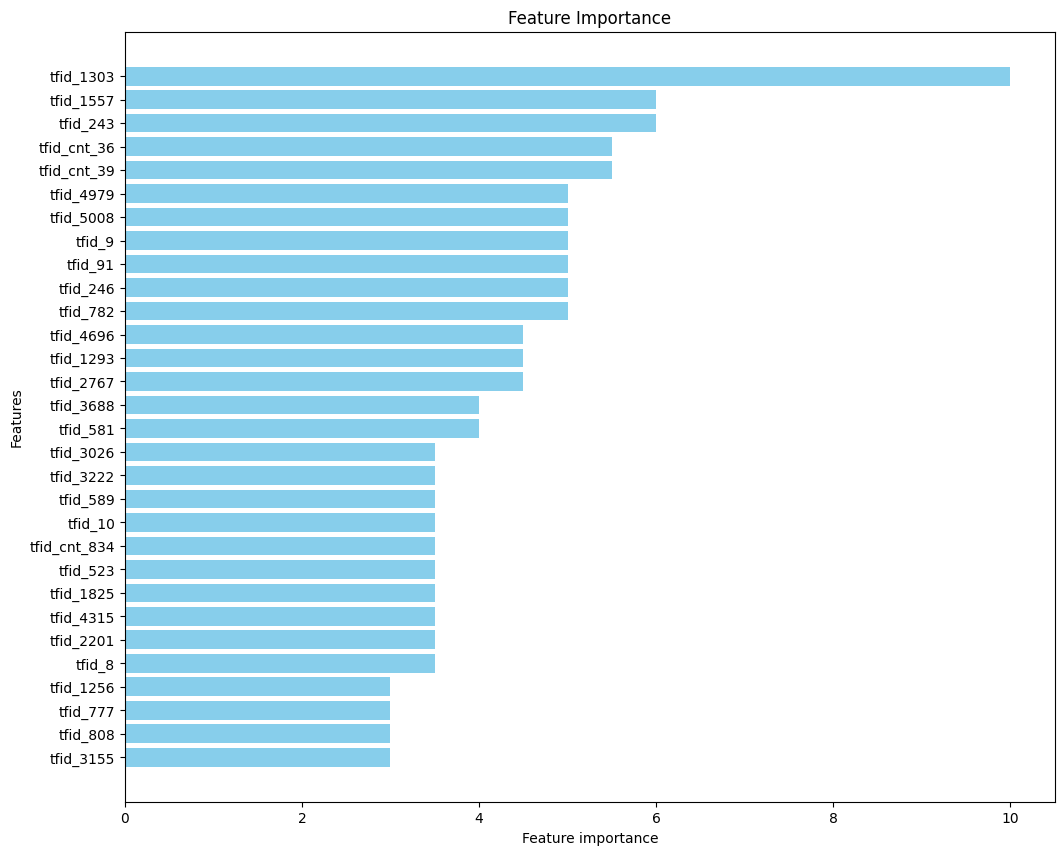

,Feature,Content_Importance,Wording_Importance,Aggregate_Importance
0,tfid_1303,3,17,10.0
1,tfid_243,4,8,6.0
2,tfid_1557,0,12,6.0
3,tfid_cnt_39,1,10,5.5
4,tfid_cnt_36,2,9,5.5
5,tfid_91,0,10,5.0
6,tfid_5008,3,7,5.0
7,tfid_4979,3,7,5.0
8,tfid_246,2,8,5.0
9,tfid_782,0,10,5.0


In [44]:
# select num of features based on the plots
# Plot the data
plt.figure(figsize=(12, 10))
top_idxs = 30

# plot options: Content_Importance, Wording_Importance, Aggregate_Importance
importance_to_plot = 'Aggregate_Importance'
plt.barh(top_features['Feature'][:top_idxs], top_features.sort_values(by=importance_to_plot, ascending=False).reset_index(drop=True)[importance_to_plot][:top_idxs], color='skyblue')
plt.xlabel('Feature importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

# fs_content[:top_idxs]
# fs_wording[:top_idxs]
# fs_aggregate[:top_idxs]
top_features.sort_values(by=importance_to_plot, ascending=False).reset_index(drop=True)[:top_idxs]

## Train LGBM

In [45]:
LOAD = True # re-train
# Define the number of splits for cross-validation
n_splits = 4
models = []
if not LOAD:
    for i in range(n_splits):
        # TODO: Change path !!!!!!!
        models.append(lgb.Booster(model_file=f'/kaggle/input/aes-15fold/fold_{i+1}.txt'))
else:
    X = train_polars.drop(columns=['content', 'wording'])
    y = train[['content', 'wording']].astype('float16')
    gkf = GroupKFold(n_splits=4)
    folds = gkf.split(X, y, groups=train['prompt_id'])
    callbacks = [log_evaluation(period=25), early_stopping(stopping_rounds=700, first_metric_only=True)]
    predictions = []
    mcrmse_scores = np.array([])
    
    top_features_list = top_features['Feature'][:top_idxs]
    # Loop through each fold of the cross-validation
    for fold_idx, (train_index, test_index) in enumerate(folds):
        
        print('fold', fold_idx)
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
        
        X_train_fold, feature_names, vectorizer, vectorizer_cnt = preprocess_data(X_train_fold, fold_indexes=train_index)
        X_test_fold, _, _, _ = preprocess_data(X_test_fold, fold_indexes=test_index, vectorizer=vectorizer, vectorizer_cnt=vectorizer_cnt)
        
        # Intersect the list of top features with the columns in X_train_fold
        existing_top_features = [feature for feature in top_features_list if feature in X_train_fold.columns]
        
        # Using the top features only
        X_train_fold = X_train_fold[existing_top_features]
        X_test_fold = X_test_fold[existing_top_features]
        
        print(X_train_fold.shape)
        
        fold_predictions = []
        fold_models = []
        
        for target in ['content', 'wording']:
            y_train_target = y_train_fold[target]
            y_test_target = y_test_fold[target]
            
            model = lgb.LGBMRegressor(
                    objective = 'regression',
                    metrics = 'rmse',
                    learning_rate = 0.01,
                    max_depth = 3,
                    num_leaves = 10,
                    colsample_bytree=0.7,
                    reg_alpha = 0.1,
                    reg_lambda = 1.0,
                    n_estimators=100,
                    random_state= 42,
                    extra_trees=True,
                    verbosity = -1)

            predictor = model.fit(X_train_fold,
                                  y_train_target,
                                  eval_names=['train', 'valid'],
                                  eval_set=[(X_train_fold, y_train_target), (X_test_fold, y_test_target)],
                                  eval_metric='rmse',
                                  callbacks=callbacks)
            
            fold_models.append(predictor)
            fold_predictions.append(predictor.predict(X_test_fold))
            # predictor.booster_.save_model(f'fold_{fold_idx}_{target}.txt')
            
        models.append(fold_models)
        predictions.append(fold_predictions)
        
        # Calculate mcrmse 
        y_true_fold = np.array(y_test_fold)
        y_pred_fold = np.array(fold_predictions).T.reshape(-1, 2)
        fold_mcrmse, _ = mcrmse(y_true_fold, y_pred_fold)    
        mcrmse_scores = np.append(mcrmse_scores, fold_mcrmse)
        print(f"Fold {fold_idx} MCRMSE: {fold_mcrmse}")
        print()
        
    print(f"MCRMSE across all folds: {np.mean(mcrmse_scores)}")

fold 0
Features Number:  53
Features Number:  81
Features Number:  102
Features Number:  5264
Features Number:  6288
Features Number:  53
Features Number:  81
Features Number:  102
Features Number:  5264
Features Number:  6288
(5108, 30)
Training until validation scores don't improve for 700 rounds
[25]	train's rmse: 1.06851	valid's rmse: 0.975776
[50]	train's rmse: 1.06711	valid's rmse: 0.975683
[75]	train's rmse: 1.06593	valid's rmse: 0.975573
[100]	train's rmse: 1.06481	valid's rmse: 0.975476
Did not meet early stopping. Best iteration is:
[94]	train's rmse: 1.06506	valid's rmse: 0.97546
Evaluated only: rmse
Training until validation scores don't improve for 700 rounds
[25]	train's rmse: 1.02426	valid's rmse: 1.06082
[50]	train's rmse: 1.02233	valid's rmse: 1.06091
[75]	train's rmse: 1.02064	valid's rmse: 1.06085
[100]	train's rmse: 1.01913	valid's rmse: 1.06103
Did not meet early stopping. Best iteration is:
[35]	train's rmse: 1.02345	valid's rmse: 1.06078
Evaluated only: rmse
Fold

# Inference 

## Inference Baseline Model

In [6]:
# content_scores = np.random.uniform(-1.73, 3.9, len(test))
# wording_scores = np.random.uniform(-1.96, 4.31, len(test))

# submission_df = pd.DataFrame({'student_id': test['student_id'],
#                               'content': content_scores,
#                               'wording': wording_scores})

# submission_df.to_csv("submission.csv", index=False)
# submission_df.head()

,student_id,content,wording
0,000000ffffff,1.654278,3.259415
1,222222cccccc,2.256449,-0.628634
2,111111eeeeee,-1.614109,-0.819957
3,333333dddddd,3.730592,-0.810054


## Inference Without LGBM

In [21]:
# MODIFY ACCORDINGLY
weights_to_submit_path = '/kaggle/input/meta-model-weights/meta_model_3.weights.h5'

X = test[['text', 'prompt_question', 'prompt_text']]

decay_steps = math.ceil((len(X) / batch_size) * epochs) 
model, deberta = create_model(decay_steps=decay_steps)
model.load_weights(weights_to_submit_path)

X = build_dataset(X['text'], X['prompt_question'], X['prompt_text'], deberta.tokenizer)

test_data = {
    'input_ids': X[0],
    'attention_mask': X[1],
    'head_mask': X[2],
    'student_id': test['student_id'],
}

ids, contents, wordings = generate_predictions(model, test_data)

submission_df = pd.DataFrame({'student_id': ids,
                              'content': contents,
                              'wording': wordings})

submission_df.to_csv("submission.csv", index=False)
submission_df.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


,student_id,content,wording
0,000000ffffff,0.000441,-0.000741
1,222222cccccc,0.000556,-0.001060
2,111111eeeeee,0.000401,-0.000998
3,333333dddddd,0.000462,-0.000885


## Inference With LGBM

In [ ]:
# TODO

# Leftovers

In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)


# Model name to load
# model_name =  "microsoft/deberta-v3-large"

# # Load DeBERTa / RoBERTa model and tokenizer
# tokenizer = AutoTokenizer.from_pretrained(model_name)
# pre_trained_model = TFAutoModel.from_pretrained(model_name)


# tokenizer.save_pretrained("deberta_v3_large_tokenizer")
# pre_trained_model.save_pretrained("deberta_v3_large_model")



# def get_embeddings(input_ids, attention_mask, model_name):
    
#     # Forward pass through pre trained model
#     outputs = pre_trained_model(input_ids=input_ids, attention_mask=attention_mask)
    
#     if model_name == 'roberta-large':
#         return outputs['pooler_output']
#     else:
#         return outputs[0]

# # Save roberta/deberta embeddings in the training set

# batch_size = 10 # ten is the biggest batch possible (can try maybe 11)
# num_samples = len(X_train['input_ids'])
# num_batches = (num_samples + batch_size - 1) // batch_size
# averaged_embeddings = []

# for i in range(num_batches):
#     start_idx = i * batch_size
#     end_idx = min((i + 1) * batch_size, num_samples)
#     inputs = X_train['input_ids'][start_idx: end_idx]
#     masks = X_train['attention_mask'][start_idx: end_idx]
    
#     embeddings = get_embeddings(input_ids=inputs, attention_mask=masks, model_name=model_name)
#     h_mask = tf.expand_dims(tf.cast(head_mask[start_idx: end_idx], dtype=tf.float32), axis=-1)
#     masked_outputs = tf.multiply(embeddings, h_mask)
#     pooled = (tf.reduce_mean(masked_outputs, axis=1)).numpy()
#     averaged_embeddings.append(pooled)
    
#     if i % int(num_batches * 0.1) == 0:
#         print(f"Batch {i}/{num_batches}")
        
#     del embeddings
#     del masked_outputs
#     del pooled
#     del h_mask
#     gc.collect()
#     tf.keras.backend.clear_session()
# # Write to a file    
# concatenated_embeddings = np.concatenate(averaged_embeddings, axis=0)
# with open('masked_pooled_deberta_embeddings.pkl', 'wb') as f:
#     pickle.dump(concatenated_embeddings, f)


# Save file to output folder

# # DeBERTa 
# file_path = '/kaggle/input/pooled-deberta-embeddings/pooled_deberta_embeddings.csv'# from input folder

# # Load masked pooled Deberta embeddings
# with open('/kaggle/input/masked-pooled-deberta-embeddings/mask_pooled_deberta_embeddings.pkl', 'rb') as f:
#     loaded_array = pickle.load(f)
# # Load embeddings
# X_train_preprocessed = pd.read_csv(file_path)


# X_train_preprocessed['embeddings'] = X_train_preprocessed['embeddings'].apply(lambda x: list(map(float, x.split(','))))
# X_train_preprocessed['masked_embeddings'] = loaded_array.tolist()
# Save a csv file
# df_to_save = df_with_embeddings['pooled_roberta_embedding'].apply(lambda x: ','.join(map(str, x)))
# df_to_save.to_csv(file_path, index=False)




# # NN with embeddings preprocessed
# def create_model_preprocessed():
#     input_shape = len(X_train_preprocessed['masked_embeddings'][0])

#     input_layer = keras.Input(shape=(input_shape, ), dtype='float32')
    
#     layer_norm = layers.LayerNormalization(name='layer_norm1')(input_layer)
    
#     reshape_input_layer = layers.Reshape((1,input_shape), name='reshape_layer')(layer_norm)
    
#     LSTM_layer = layers.LSTM(512, return_sequences=True, name='LSTM_layer1', activation='linear')(reshape_input_layer)
    
#     layer_norm = layers.LayerNormalization(name='layer_norm2')(LSTM_layer)
    
#     act = layers.Activation(keras.activations.tanh, name='tanh1')(layer_norm)
    
#     LSTM_layer = layers.LSTM(32, return_sequences=False, name='LSTM_layer2', activation='linear',)(act)
    
#     layer_norm = layers.LayerNormalization(name='layer_norm3')(LSTM_layer)
    
#     act = layers.Activation(keras.activations.tanh, name='tanh2')(layer_norm)
    
#     hidden_layer = layers.Dense(16, activation='linear', name='dense_layer')(act)
    
#     dropout = layers.Dropout(0.3, name='dropout_layer')(hidden_layer)
    
#     # batch_norm = layers.BatchNormalization(name='batch_norm')(dropout)

#     output_layer = layers.Dense(2, activation='linear', name='output_layer')(dropout)
    
#     model = keras.Model(inputs=input_layer, outputs=output_layer)

#     for layer in model.layers:
#         layer.trainable = True
        
    
#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(loss=mcrmse, optimizer=opt)
    
#     return model

# model = create_model_preprocessed()
# model.summary()



# Train prepocessed model (head only) without validation

# Checkpoint callback
# ckptcb = keras.callbacks.ModelCheckpoint(
#     "best_model" + ".weights.h5",
#     monitor="loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
# )    

# history = model.fit(x=X_train_input,
#                     y=Y_train_np,
#                     epochs=25,
#                     batch_size=4,
#                     callbacks=[ckptcb],
#                     verbose=2)



# Train prepocessed model (head only) with K folds

# X_train_input = np.array(X_train_preprocessed['masked_embeddings'].tolist())
# Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)

# # Initialize the KFold object
# kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

# # Initialize an empty list to store the validation losses
# val_losses = []
# histories = []

# Y_train_np = Y_train.numpy()

# # Iterate over each fold
# i = 0
# for train_index, val_index in kf.split(X_train_input, Y_train_np):
    
#     print(f"Fold {i + 1}")
#     i += 1
    
#     # Split data into training and validation sets
#     X_train_fold, X_val_fold = X_train_input[train_index], X_train_input[val_index]
#     Y_train_fold, Y_val_fold = Y_train_np[train_index], Y_train_np[val_index]
    
#     # Create and compile your model
#     model = create_model()
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
#     # Train the model
    
#     # Get the validation loss from the last epoch
#     val_loss = min(history.history['val_loss'])
#     val_losses.append(val_loss)
#     histories.append(history)
#     print()

# # Calculate the mean validation loss
# mean_val_loss = np.mean(val_losses)
# print("Mean Validation Loss:", mean_val_loss)

# # Plot training and val losses across folds
# for i, history in enumerate(histories):
#     train_losses = history.history['loss']
#     val_losses = history.history['val_loss']
#     epochs = range(1, len(train_losses) + 1)

#     # Plotting losses
#     plt.figure(figsize=(12, 5))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, train_losses, 'b', label='Training loss')
#     plt.plot(epochs, val_losses, 'r', label='Validation loss')
#     plt.title(f'Training and Validation Loss Fold {i + 1}')
#     plt.xlabel('Epochs')
#     plt.ylabel('Loss')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

In [ ]:
# # NN with embeddings preprocessed (head only)
# def create_model_preprocessed():
#     input_shape = 1024 

#     input_layer = keras.Input(shape=(input_shape, ), dtype='float32')

#     x = layers.LayerNormalization(name='layer_norm1')(input_layer)
#     x = layers.Reshape((1,input_shape), name='reshape_layer')(x)
    
#     x = layers.LSTM(512, return_sequences=True, name='LSTM_layer1', activation='linear')(x)
#     x = layers.LayerNormalization(name='layer_norm2')(x)
#     x = layers.Activation(keras.activations.tanh, name='tanh1')(x)
#     x = layers.LSTM(32, return_sequences=False, name='LSTM_layer2', activation='linear',)(x)
#     x = layers.LayerNormalization(name='layer_norm3')(x)
    
#     x = layers.Activation(keras.activations.tanh, name='tanh2')(x)
#     x = layers.Dense(16, activation='linear', name='dense_layer')(x)
#     x = layers.Dropout(0.3, name='dropout_layer')(x)

#     output_layer = layers.Dense(2, activation='linear', name='output_layer')(x)
    
#     model = keras.Model(inputs=input_layer, outputs=output_layer)

#     for layer in model.layers:
#         layer.trainable = True
        
    
#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(loss=mcrmse, optimizer=opt)
    
#     return model

# # model_preprocessed = create_model_preprocessed()
# # model_preprocessed.load_weights("/kaggle/input/model-weights-1/best_model.weights.h5")
# # model_preprocessed.summary()




# Save file to output folder

# DeBERTa 
# file_path = '/kaggle/input/pooled-deberta-embeddings/pooled_deberta_embeddings.csv'

# # Load masked pooled Deberta embeddings
# with open('/kaggle/input/masked-pooled-deberta-embeddings/mask_pooled_deberta_embeddings.pkl', 'rb') as f:
#     loaded_array = pickle.load(f)
# # Load embeddings
# X_train_preprocessed = pd.read_csv(file_path)

# X_train_preprocessed['embeddings'] = X_train_preprocessed['embeddings'].apply(lambda x: list(map(float, x.split(','))))
# X_train_preprocessed['masked_embeddings'] = loaded_array.tolist()

# # Save a csv file
# df_to_save = df_with_embeddings['pooled_roberta_embedding'].apply(lambda x: ','.join(map(str, x)))
# df_to_save.to_csv(file_path, index=False)



# # Train prepocessed model (head only) with K folds

# X_train_input = np.array(X_train_preprocessed['masked_embeddings'].tolist())
# Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)
# Y_train_np = Y_train.numpy()

# # Initialize the KFold object
# kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
# folds = kf.split(X_train_input, Y_train_np)

# # Initialize an empty list to store the validation losses
# val_losses = []
# histories = []

# # Iterate over each fold
# i = 0
# for train_index, val_index in folds:
    
#     print(f"Fold {i + 1}")
#     i += 1
    
#     # Split data into training and validation sets
#     X_train_fold, X_val_fold = X_train_input[train_index], X_train_input[val_index]
#     Y_train_fold, Y_val_fold = Y_train_np[train_index], Y_train_np[val_index]
    
#     # Create and compile your model
#     model = create_model_preprocessed()
#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
#     # Checkpoint callback
#     ckptcb = keras.callbacks.ModelCheckpoint(
#         f"model_fold_{i}" + ".weights.h5",
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#     )    

#     # Train the model
#     history = model.fit(x=X_train_fold,
#                         y=Y_train_fold,
#                         epochs=100,
#                         batch_size=4,
#                         validation_data=(X_val_fold, Y_val_fold),
#                         callbacks=[ckptcb, early_stopping],
#                         verbose=2)
    
#     # Get the validation loss from the last epoch
#     val_loss = min(history.history['val_loss'])
#     val_losses.append(val_loss)
#     histories.append(history)
#     print()

# # Calculate the mean validation loss
# mean_val_loss = np.mean(val_losses)
# print("Mean Validation Loss:", mean_val_loss)

In [ ]:
# # Training full model 5 folds

# # Transferring weights 
# def transfer_weights(model_preprocessed, model):
#     for layer in model.layers:
#         origin_name = layer.name
#         new_name = f"{layer.name}_full"
#         layer.name = new_name    # Change the internal name attribute

#         if any(origin_name == preprocessed_layer.name for preprocessed_layer in model_preprocessed.layers):
#             layer.set_weights(model_preprocessed.get_layer(name=origin_name).get_weights())
#             layer.trainable = True
#     return model
# #     model.summary() 
# #     model_preprocessed.summary()


# # Train prepocessed model with K folds
# tokenized_summaries_np = {
#     'input_ids': tokenized_summaries['input_ids'].numpy(),
#     'attention_mask': tokenized_summaries['attention_mask'].numpy(),
#     'head_mask': head_mask.numpy(),
# }

# Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)
# Y_train_np = Y_train.numpy()

# # Initialize the KFold object
# kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
# folds = kf.split(X_train_input, Y_train_np)

# # Initialize an empty list to store the validation losses
# val_losses = []
# histories = []

# # Iterate over each fold
# i = 0
# for train_index, val_index in folds:
            
#     print(f"Fold {i + 1}")
#     i += 1
    
#     # Split data into training and validation sets
#     train_input_ids_fold, train_attention_mask_fold, train_head_mask_fold = tokenized_summaries_np['input_ids'][train_index], tokenized_summaries_np['attention_mask'][train_index], tokenized_summaries_np['head_mask'][train_index]
#     val_input_ids_fold, val_attention_mask_fold, val_head_mask_fold = tokenized_summaries_np['input_ids'][val_index], tokenized_summaries_np['attention_mask'][val_index], tokenized_summaries_np['head_mask'][val_index]
#     Y_train_fold, Y_val_fold = Y_train_np[train_index], Y_train_np[val_index]
    
#     # Create and compile your model
#     model_preprocessed = create_model_preprocessed()
#     model_preprocessed.load_weights(f'/kaggle/input/head-model-weights-folds/head_model_weights/model_fold_{i}.weights.h5')
#     model, _ = create_model()
#     model = transfer_weights(model_preprocessed, model)
    
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#     # Checkpoint callback
#     ckptcb = keras.callbacks.ModelCheckpoint(
#         f"full_model_fold_{i}" + ".weights.h5",
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#     )    

#     # Train the model
#     history = model.fit(x=[train_input_ids_fold, train_attention_mask_fold, train_head_mask_fold],
#                         y=Y_train_fold,
#                         epochs=100,
#                         batch_size=4,
#                         validation_data=([val_input_ids_fold, val_attention_mask_fold, val_head_mask_fold], Y_val_fold),
#                         callbacks=[ckptcb, early_stopping],
#                         verbose=1)
    
#     # Get the validation loss from the last epoch
#     val_loss = min(history.history['val_loss'])
#     val_losses.append(val_loss)
#     histories.append(history)
#     print()

# # Calculate the mean validation loss
# mean_val_loss = np.mean(val_losses)
# print("Mean Validation Loss:", mean_val_loss)

In [ ]:
# Train full model no folds all data


# Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)
# Y_train_np = Y_train.numpy()

# Checkpoint callback
# ckptcb = keras.callbacks.ModelCheckpoint(
#     "best_model" + ".weights.h5",
#     monitor="loss",
#     save_best_only=True,
#     save_weights_only=True,
#     mode="min",
# )    

# history = model.fit(x=[tokenized_summaries['input_ids'], tokenized_summaries['attention_mask'], head_mask],
#                     y=Y_train_np,
#                     epochs=6,
#                     batch_size=4,
#                     callbacks=[ckptcb],
#                     verbose=1)


In [ ]:
# Train model with augmentation folds


# tokenized_summaries_aug = tokenizer.batch_encode_plus(augmented_labeled_data['input'].tolist(),
#                                               add_special_tokens=True,
#                                               truncation=True,
#                                               padding='max_length',
#                                               return_tensors='tf',
#                                               max_length=MAX_SUMMARY_LENGTH,
#                                               return_attention_mask = True)
# del tokenized_summaries_aug['token_type_ids']

# # Create head mask that excludes anything but sep + prefix2 + train['text']
# head_mask_aug = np.zeros(tokenized_summaries_aug['input_ids'].shape)
# for i, summary in enumerate(tokenized_summaries_aug['input_ids'].numpy()):
#     use_full = False
#     for j, token in enumerate(summary):
#         if token == tokenizer.sep_token_id:
#             use_full = not use_full
#         head_mask_aug[i][j] = (1 if use_full else 0) 
# head_mask_aug = tf.constant(head_mask_aug)

# # Train prepocessed model with K folds
# tokenized_summaries_np = {
#     'input_ids': tokenized_summaries_aug['input_ids'].numpy(),
#     'attention_mask': tokenized_summaries_aug['attention_mask'].numpy(),
#     'head_mask': head_mask_aug.numpy(),
# }

# Y_train = tf.constant(augmented_labeled_data[['content', 'wording']].values, dtype=tf.float32)
# Y_train_np = Y_train.numpy()

# # Initialize the KFold object
# kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)
# folds = kf.split(tokenized_summaries_np['input_ids'], Y_train_np)

# # Initialize an empty list to store the validation losses
# val_losses = []
# histories = []

# # Iterate over each fold
# i = 0
# for train_index, val_index in folds:
            
#     print(f"Fold {i + 1}")
#     i += 1
    
#     # Split data into training and validation sets
#     train_input_ids_fold, train_attention_mask_fold, train_head_mask_fold = tokenized_summaries_np['input_ids'][train_index], tokenized_summaries_np['attention_mask'][train_index], tokenized_summaries_np['head_mask'][train_index]
#     val_input_ids_fold, val_attention_mask_fold, val_head_mask_fold = tokenized_summaries_np['input_ids'][val_index], tokenized_summaries_np['attention_mask'][val_index], tokenized_summaries_np['head_mask'][val_index]
#     Y_train_fold, Y_val_fold = Y_train_np[train_index], Y_train_np[val_index]
    
#     # Create and compile your model
#     model, _ = create_model()
#     model.load_weights(f'/kaggle/input/no-aug-model-folds-weights/no-aug-model-folds-weights/full_model_fold_{i}.weights.h5')
#     early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    
#     # Checkpoint callback
#     ckptcb = keras.callbacks.ModelCheckpoint(
#         f"aug_full_model_fold_{i}" + ".weights.h5",
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#     )    

#     # Train the model
#     history = model.fit(x=[train_input_ids_fold, train_attention_mask_fold, train_head_mask_fold],
#                         y=Y_train_fold,
#                         epochs=100,
#                         batch_size=4,
#                         validation_data=([val_input_ids_fold, val_attention_mask_fold, val_head_mask_fold], Y_val_fold),
#                         callbacks=[ckptcb, early_stopping],
#                         verbose=1)
    
#     # Get the validation loss from the last epoch
#     val_loss = min(history.history['val_loss'])
#     val_losses.append(val_loss)
#     histories.append(history)
    
#     del model 
#     gc.collect()
#     print()

# # Calculate the mean validation loss
# mean_val_loss = np.mean(val_losses)
# print("Mean Validation Loss:", mean_val_loss)

In [ ]:
# Predicting Meta Psuedo Labels

# augmented_data["text"] = augmented_data["text"].apply(lambda x: spell(x))
# augmented_data['input'] = prefix1 + augmented_data['prompt_question'] + sep + prefix2 + augmented_data['text']
# augmented_data['input'][0]

# tokenized_summaries_aug = tokenizer.batch_encode_plus(augmented_data['input'].tolist(),
#                                               add_special_tokens=True,
#                                               truncation=True,
#                                               padding='max_length',
#                                               return_tensors='tf',
#                                               max_length=MAX_SUMMARY_LENGTH,
#                                               return_attention_mask = True)
# del tokenized_summaries_aug['token_type_ids']

# # Create head mask that excludes anything but sep + prefix2 + train['text']
# head_mask_aug = np.zeros(tokenized_summaries_aug['input_ids'].shape)
# for i, summary in enumerate(tokenized_summaries_aug['input_ids'].numpy()):
#     use_full = False
#     for j, token in enumerate(summary):
#         if token == tokenizer.sep_token_id:
#             use_full = not use_full
#         head_mask_aug[i][j] = (1 if use_full else 0) 
# head_mask_aug = tf.constant(head_mask_aug)

# aug_input = {
#     'input_ids': tokenized_summaries_aug['input_ids'],
#     'attention_mask': tokenized_summaries_aug['attention_mask'],
#     'head_mask': head_mask_aug,
#     'student_id': augmented_data['student_id']
# }

# # ids, contents, wordings = generate_predictions(model, aug_input) # uncomment if not using folds

# preds = []
# for i in range(1,6):
#     model, _ = create_model()
#     model.load_weights(f'/kaggle/input/no-aug-model-folds-weights/no-aug-model-folds-weights/full_model_fold_{i}.weights.h5')
    
#     ids, contents, wordings = generate_predictions(model, aug_input)
#     preds.append([ids, contents, wordings])
#     del model
#     gc.collect()
    
# # Calculate mean predictions
# contents = np.stack([pred[1] for pred in preds]).mean(axis=0)
# wordings = np.stack([pred[2] for pred in preds]).mean(axis=0)

# augmented_data['content'] = contents
# augmented_data['wording'] = wordings
# augmented_data.to_csv("augmented_labeled_data.csv")

# augmented_labeled_data = pd.read_csv('/kaggle/input/augmented-labeled-data-folds/augmented_labeled_data.csv')
# augmented_labeled_data['input'] = prefix1 + augmented_labeled_data['prompt_question'] + sep + prefix2 + augmented_labeled_data['text']

In [ ]:
# # NN full model
# def create_model(input_shape=(1575,), embeddings_len=1024):
#     pre_trained_model_instance = PreTrainedModel(pre_trained_model, name="deberta_layer")

#     # Input layers
#     input_ids = keras.Input(shape=input_shape, dtype='int32', name='input_ids')
#     attention_mask = keras.Input(shape=input_shape, dtype='int32', name='attention_mask')
#     head_mask = keras.Input(shape=input_shape, dtype='float32', name='head_mask')
    
#     # Create embeddings and mask pool them
#     deberta = pre_trained_model_instance(input_ids, attention_mask)
#     h_mask = layers.Lambda(lambda x: tf.expand_dims(tf.cast(x, dtype=tf.float32), axis=-1), name='expand_dims')(head_mask)
#     masked_outputs = layers.Lambda(lambda x: tf.multiply(x[0], x[1]), output_shape=(1575, 1024,), name='masked_embeddings')([deberta, h_mask])
#     avg_pooling = layers.GlobalAveragePooling1D()(masked_outputs)
    
#     # Head of NN
#     x = layers.LayerNormalization(name='layer_norm1')(avg_pooling)
#     x = layers.Reshape((1, embeddings_len), name='reshape_layer')(x)
    
#     x = layers.LSTM(512, return_sequences=True, name='LSTM_layer1', activation='linear')(x)
#     x = layers.LayerNormalization(name='layer_norm2')(x)
#     x = layers.Activation(keras.activations.tanh, name='tanh1')(x)
#     x = layers.LSTM(32, return_sequences=False, name='LSTM_layer2', activation='linear',)(x)
#     x = layers.LayerNormalization(name='layer_norm3')(x)
#     x = layers.Activation(keras.activations.tanh, name='tanh2')(x)
    
#     x = layers.Dense(16, activation='linear', name='dense_layer')(x)
#     x = layers.Dropout(0.3, name='dropout_layer')(x)
#     output_layer = layers.Dense(2, activation='linear', name='output_layer')(x)
    
#     model = keras.Model(inputs=[input_ids, attention_mask, head_mask], outputs=output_layer)

#     for layer in model.layers:
#         layer.trainable = True
    
#     opt = keras.optimizers.Adam(learning_rate=lr_schedule)
#     model.compile(loss=mcrmse, optimizer=opt)
    
#     return model, pre_trained_model_instance

# # model, deberta_model = create_model()
# # model.summary()

# # model.load_weights("/kaggle/input/no-aug-model-weights/no_augmentation_model.weights.h5")
# # deberta_model.summary()

In [ ]:
# sep = f" {tokenizer.sep_token} "
# prefix1 = "Think through this step by step: "
# prefix2 = "Pay attention to the content and wording: "
# MAX_SUMMARY_LENGTH = 1500 + len(prefix1) + len(prefix2)

# # Tokenization + Head Mask creation
# def preprocess_summary(data, label=None):
    
#     print(data.shape)
#     summary, prompt_question = data
#     summary = summary.numpy().decode()
#     prompt_question= prompt_question.numpy().decode()
    
#     summary = spell(summary)
#     summary = prefix1 + prompt_question + sep + prefix2 + summary
#     # Tokenize the summary
#     tokenized = tokenizer(summary,
#                           truncation=True,
#                           padding='max_length',
#                           return_tensors='tf',
#                           max_length=MAX_SUMMARY_LENGTH,
#                           return_attention_mask=True)
    
#     input_ids = tokenized['input_ids']
#     attention_mask = tokenized['attention_mask']

#     # Create head mask
#     head_mask = np.zeros_like(input_ids)
#     use_full = False
#     for j, token in enumerate(input_ids[0]):
#         if token == tokenizer.sep_token_id:
#             use_full = not use_full
#         head_mask[0][j] = 1 if use_full else 0
#     head_mask = tf.constant(head_mask, dtype=tf.int32)
      
#     if label is None:
#         return input_ids[0], attention_mask[0], head_mask[0]
#     else:
#         return (input_ids[0], attention_mask[0], head_mask[0]), label

# # wrapper function to work with keras dataloader
# def preprocess_summary_wrapper(data, label=None):
#     if label is None:
#         output = tf.py_function(preprocess_summary, [data], [tf.int32])
#     else:
#         output = tf.py_function(preprocess_summary, [data, label], [tf.int32, tf.float64])
#         output[1].set_shape([2])
        
#     output[0][0].set_shape([MAX_SUMMARY_LENGTH])
#     output[0][1].set_shape([MAX_SUMMARY_LENGTH])
#     output[0][2].set_shape([MAX_SUMMARY_LENGTH])
#     output[0].set_shape([3])
#     return output[0], output[1]

# # split in NN to inout ids, attention mask and head mask
# def split_input(inputs):
#     split_tensors = tf.split(inputs, num_or_size_splits=3, axis=1)
#     # Remove the redundant dimension
#     input_ids = tf.cast(tf.squeeze(split_tensors[0], axis=1), tf.int32)
#     attention_mask = tf.cast(tf.squeeze(split_tensors[1], axis=1), tf.int32)
#     head_mask = tf.cast(tf.squeeze(split_tensors[2], axis=1), tf.float32)
#     return input_ids, attention_mask, head_mask

# Data Loader

# def build_dataset(data, labels=None, batch_size=4, cache=True, shuffle=True):
#     AUTOTUNE = tf.data.AUTOTUNE

#     dataset = tf.data.Dataset.from_tensor_slices(data) if labels is None else tf.data.Dataset.from_tensor_slices((data, labels))    
#     dataset = dataset.cache() if cache else dataset
    
#     # tokenize + preprocess summaries
#     if labels is None:
#         dataset = dataset.map(lambda x: preprocess_summary_wrapper(x), num_parallel_calls=2)
#     else:
#         dataset = dataset.map(lambda x, y: preprocess_summary_wrapper(x, y), num_parallel_calls=2)
        
#     dataset = dataset.shuffle(buffer_size=len(data), seed=random_seed) if shuffle else dataset
        
#     # CAN ADD AUGMENTATION PREPROCESS HERE
    
#     # Batch and prefetch the dataset
#     dataset = dataset.batch(batch_size, drop_remainder=True)
#     dataset = dataset.prefetch(AUTOTUNE)
    
#     return dataset

In [ ]:
    # Head of NN
#     x = layers.LayerNormalization(name='layer_norm1')(avg_pooling)
#     x = layers.Reshape((1, embeddings_len), name='reshape_layer')(x)
    
#     x = layers.LSTM(64, return_sequences=True, name='LSTM_layer1', activation='linear')(x)
#     x = layers.LayerNormalization(name='layer_norm2')(x)
#     x = layers.Activation(keras.activations.tanh, name='tanh1')(x)
#     x = layers.LSTM(16, return_sequences=False, name='LSTM_layer2', activation='linear',)(x)
#     x = layers.LayerNormalization(name='layer_norm3')(x)
#     x = layers.Activation(keras.activations.tanh, name='tanh2')(x)
#     x = layers.Dropout(0.3, name='dropout_layer')(x)
    
#     x = layers.Dense(16, activation='linear', name='dense_layer')(x)

In [ ]:
# # Auto correcting spellings of all summaries
# sep = f" {tokenizer.sep_token} "

# prefix1 = "Think through this step by step: "
# prefix2 = "Pay attention to the content and wording: "

# train["text"] = train["text"].apply(lambda x: spell(x))
# train['input'] = prefix1 + train['prompt_question'] + sep + prefix2 + train['text']
# print(train['input'][0])

# # Tokenize text data
# MAX_SUMMARY_LENGTH = 1500 + len(prefix1) + len(prefix2)

# tokenized_summaries = tokenizer.batch_encode_plus(train['input'].tolist(),
#                                               add_special_tokens=False,
#                                               truncation=True,
#                                               padding='max_length',
#                                               return_tensors='tf',
#                                               max_length=MAX_SUMMARY_LENGTH,
#                                               return_attention_mask=True)
# del tokenized_summaries['token_type_ids']

# # Create head mask that excludes anything but sep + prefix2 + train['text']
# head_mask = np.zeros(tokenized_summaries['input_ids'].shape)
# for i, summary in enumerate(tokenized_summaries['input_ids'].numpy()):
#     use_full = False
#     for j, token in enumerate(summary):
#         if token == tokenizer.sep_token_id:
#             use_full = not use_full  
#         head_mask[i][j] = (1 if use_full else 0) 
# head_mask = tf.constant(head_mask)
# head_mask






# # DeBERTa 
# file_path = '/kaggle/input/pooled-deberta-embeddings/pooled_deberta_embeddings.csv'# from input folder

# # Load masked pooled Deberta embeddings
# with open('/kaggle/input/masked-pooled-deberta-embeddings/masked_pooled_deberta_embeddings_no_title.pkl', 'rb') as f:
#     loaded_array = pickle.load(f)
# # Load embeddings
# X_train_preprocessed = pd.read_csv(file_path)


# X_train_preprocessed['embeddings'] = X_train_preprocessed['embeddings'].apply(lambda x: list(map(float, x.split(','))))
# X_train_preprocessed['masked_embeddings'] = loaded_array.tolist()
# # Save a csv file
# # df_to_save = df_with_embeddings['pooled_roberta_embedding'].apply(lambda x: ','.join(map(str, x)))
# # df_to_save.to_csv(file_path, index=False)




# Y_train = tf.constant(train[['content', 'wording']].values, dtype=tf.float32)
# Y_train_np = Y_train.numpy()
# X_train_input = np.array(X_train_preprocessed['masked_embeddings'].tolist())

# # The loss function
# def mcrmse(y_true, y_pred):
#     columnwise_mse = tf.reduce_mean(tf.square(y_true - y_pred), axis=0)
#     return tf.reduce_mean(tf.sqrt(columnwise_mse), axis=-1)

# init_lr = 0.00015
# lr_schedule = tf.keras.optimizers.schedules.CosineDecay(init_lr, decay_steps=100000)




# # def concat_embedding(x):
# #     expanded_text_embedding = tf.expand_dims(prefix_embed, axis=0)
# #     tiled_text_embedding = tf.tile(expanded_text_embedding, [tf.shape(x)[0], 1, 1])
# #     expanded_input_tensor = tf.expand_dims(x, axis=1)
# #     return tf.concat([tiled_text_embedding, expanded_input_tensor], axis=1)

# # # Use prefix2 embed
# #
# # prefix_tensor = tokenizer.encode(prefix, add_special_tokens=False, return_tensors='tf')
# # tokenized_prefix = tokenizer.encode(prefix2, add_special_tokens=False, return_tensors='tf')
# # prefix_len = len(tokenized_prefix)
# # prefix_embed = pre_trained_model(tokenized_prefix)[0]
# # prefix_embed = tf.cast(tf.reduce_mean(prefix_embed, axis=1), dtype=tf.float16)

# # NN with embeddings preprocessed
# def create_model_preprocessed():
#     input_shape = len(X_train_preprocessed['masked_embeddings'][0])
#     input_layer = keras.Input(shape=(input_shape, ), dtype='float32')
    
#     x = layers.LayerNormalization(name='layer_norm1')(input_layer)
#     x = layers.Reshape((1,input_shape,), name='reshape_layer')(x)
#     x = layers.LSTM(128, return_sequences=True, name='LSTM_layer1', activation='linear')(x)
#     x = layers.LayerNormalization(name='layer_norm2')(x)
#     x = layers.Activation(keras.activations.tanh, name='tanh1')(x)
    
#     x = layers.LSTM(32, return_sequences=True, name='LSTM_layer2', activation='linear')(x)
#     x = layers.LayerNormalization(name='layer_norm3')(x)
#     x = layers.Activation(keras.activations.tanh, name='tanh2')(x)
#     x = layers.Dropout(0.4, name='dropout_layer')(x)
#     x = layers.GlobalAveragePooling1D()(x)
    
# #     x = layers.Dense(16, activation='linear', name='dense_layer')(x)
# #     x = layers.Dropout(0.5, name='dropout_layer3')(x)

#     output_layer = layers.Dense(2, activation='linear', name='output_layer')(x)
    
#     model = keras.Model(inputs=input_layer, outputs=output_layer)

#     for layer in model.layers:
#         layer.trainable = True

#     opt = keras.optimizers.Adam(learning_rate=lr_schedule, use_ema=True)
#     model.compile(loss=mcrmse, optimizer=opt)
    
#     return model

# model = create_model_preprocessed()
# model.summary()






# # Train head only model
# val_losses = []
# histories = []
# gkf = GroupKFold(n_splits=4)
# folds = gkf.split(X_train_input, Y_train_np, groups=train['prompt_id'])

# for i, (train_index, val_index) in enumerate(folds):
#     print(f"Fold {i + 1}")
    
#     # Split data into training and validation sets
#     X_train_fold, X_val_fold = X_train_input[train_index], X_train_input[val_index]
#     Y_train_fold, Y_val_fold = Y_train_np[train_index], Y_train_np[val_index]
    
#     # Create and compile your model
#     model = create_model_preprocessed()
#     early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#     ema = keras.callbacks.SwapEMAWeights(swap_on_epoch=True)
#     # Checkpoint callback
# #     ckptcb = keras.callbacks.ModelCheckpoint(
# #         f"model_fold_{i}" + ".weights.h5",
# #         monitor="val_loss",
# #         save_best_only=True,
# #         save_weights_only=True,
# #         mode="min",
# #     )    

#     # Train the model
#     history = model.fit(x=X_train_fold,
#                         y=Y_train_fold,
#                         epochs=100,
#                         batch_size=4,
#                         validation_data=(X_val_fold, Y_val_fold),
#                         callbacks=[ema, early_stopping],
#                         verbose=2)
    
#     # Get the validation loss from the last epoch
#     val_loss = min(history.history['val_loss'])
#     val_losses.append(val_loss)
#     histories.append(history)
#     print()

# # Calculate the mean validation loss
# mean_val_loss = np.mean(val_losses)
# print("Mean Validation Loss:", mean_val_loss)




# **Results**

# REAL RESULTS

# baseline no grouped KFolds: 0.4437254548072815
# baseline with grouped KFolds: 0.5310284495353699
# From now on everything will be with grouped KFolds
# EMA: 0.5303183048963547
# EMA + lr_decay_steps=100000 + LSTM1=128 + LSTM2=64 + Dropout_after_LSTM2=0.6: 0.5258100032806396
# EMA + lr_decay_steps=100000 + LSTM1=128 + LSTM2=32 + Dropout_after_LSTM2=0.4: 0.5223950520157814


# FAKE RESULTS:
# group: 0.421 | 0.41956
# with regularization everywhere: 0.6671039313077927
# with reg=0.0001: 0.48
# with reg=1e-5: 0.4328196793794632
# without Dense layers of 16: 0.4203761890530586
# reduce Dropout to 0.2: 0.415641151368618
# dropout: 0.5, dense: relu +32, LSTM: 64: 0.44807666540145874 (large gap :> ) 
# With EMA: 0.4412180408835411 (keeped the large gaps)

In [ ]:
# # Full Model Baseline
# def create_model(input_shape=(1575,), embeddings_len=1024):
    
#     # Instances
#     pre_trained_model_instance = PreTrainedModel(pre_trained_model, name="deberta_layer")
#     expand_dims_instance = layers.Lambda(lambda x: tf.expand_dims(tf.cast(x, dtype=tf.float32), axis=-1), name=f'expand_dims')
#     mask_instance = layers.Lambda(lambda x: tf.multiply(x[0], x[1]), output_shape=(1575, embeddings_len,), name='masked_embeddings')
#     avg_pooling_instance = layers.GlobalAveragePooling1D()
#     reshape_instance1 = layers.Reshape((1, -1), name='reshape_layer1')
#     reshape_instance2 = layers.Reshape((1, -1), name='reshape_layer2')
#     dense_instance = layers.Dense(2, activation='linear')
    
#     # The NN starts from here
    
#     # Input layers
#     input_ids = keras.Input(shape=input_shape, dtype='int32', name='input_ids')
#     attention_mask = keras.Input(shape=input_shape, dtype='int32', name='attention_mask')
#     head_mask = keras.Input(shape=input_shape, dtype='float32', name='head_mask')
    
#     # Create embeddings and get all hidden states
#     deberta = pre_trained_model_instance(input_ids, attention_mask)
    
#     # Mask pooling all hidden states of pre-trained model
#     pooled_hidden_states = []
#     for i in range(len(deberta)):
#         h_mask = expand_dims_instance(head_mask)
#         masked_outputs = mask_instance([deberta[-i], h_mask])
#         avg_pooling_layer = avg_pooling_instance(masked_outputs)
#         reshape_layer = reshape_instance1(avg_pooling_layer)
#         pooled_hidden_states.append(reshape_layer)
        
#     # Concatenate all the hidden states an forward pass through LSTM
#     x = layers.Concatenate(axis=1)(pooled_hidden_states)
#     x = layers.LSTM(embeddings_len, return_sequences=False)(x)
    
#     # Multi-sample Dropout
#     x = layers.Dropout(0.1)(x)
#     dropoutList = [reshape_instance2(dense_instance(layers.Dropout((i + 1) * 0.1)(x))) for i in range(5)]
#     x = layers.Concatenate(axis=1)(dropoutList)
    
#     output_layer = layers.GlobalAveragePooling1D()(x)
#     # output_layer = layers.Dense(2, activation='linear', name='output_layer')(x)
    
    
#     model = keras.Model(inputs=[input_ids, attention_mask, head_mask], outputs=output_layer)
#     for layer in model.layers:
#         layer.trainable = True
    
#     opt = keras.optimizers.AdamW(learning_rate=lr_schedule, use_ema=True)
#     model.compile(loss=mcrmse, optimizer=opt)
#     return model, pre_trained_model_instance

# # model, deberta_model = create_model()
# # model.summary()

# # model.load_weights("/kaggle/input/no-aug-model-weights/no_augmentation_model.weights.h5")
# # deberta_model.summary()

In [ ]:
# from transformers import AutoConfig, TFAutoModelForSequenceClassification
# model_config = AutoConfig.from_pretrained("microsoft/deberta-v3-large", num_labels=2)
# model_config.update({
#     "hidden_dropout_prob": 0.,
#     "attention_probs_dropout_prob": 0.,
#     "problem_type": "regression",
# })
# model = TFAutoModelForSequenceClassification.from_pretrained('microsoft/deberta-v3-large', config=model_config)
# tokenizer = AutoTokenizer.from_pretrained('microsoft/deberta-v3-large')

# # Debug to check if worked:
# print(model.config.hidden_dropout_prob)
# print(model.config.hidden_dropout_prob)
# print(model.config.problem_type)
# print(model.config.num_labels)

# class DebertaRegressor(keras.Model):
#     def __init__(self, model_path, trainable=False, num_layers_to_freeze=8, name=None, **kwargs):
#         super().__init__(name=name, **kwargs)
#         self.model_config = AutoConfig.from_pretrained(model_path, num_labels=2) 
#         self.model_config.update({
#             "hidden_dropout_prob": 0.,
#             "attention_probs_dropout_prob": 0.,
#             "problem_type": "regression",
#         })
#         self.model = TFAutoModelForSequenceClassification.from_pretrained(model_path, config=self.model_config)
#         self.tokenizer = AutoTokenizer.from_pretrained(model_path)
        
#         # Dynamically create properties from pre-trained model
# #         for prop_name, prop in inspect.getmembers(self.model):
# #             if not prop_name.startswith('_') and not inspect.ismethod(prop):
# #                 setattr(self.__class__, prop_name, prop)

#     def call(self, input_ids, attention_mask):
#         # Call the pre trained model and get the last hidden state
#         return self.model(input_ids=input_ids, attention_mask=attention_mask).logits

# # HyperParameters
# init_lr = 0.00015
# batch_size = 8
# epochs = 3


# def build_model(input_shape=(1575,), decay_steps=10000, warmup_steps=100):
#     # deberta instance
#     deberta = DebertaRegressor("microsoft/deberta-v3-large")
    
#     input_ids = keras.Input(shape=input_shape, dtype='int32', name='input_ids')
#     attention_mask = keras.Input(shape=input_shape, dtype='int32', name='attention_mask')
#     output_layer = deberta(input_ids, attention_mask)
    
#     model = keras.Model(inputs=[input_ids, attention_mask], outputs=output_layer)
#     lr_schedule = keras.optimizers.schedules.CosineDecay(initial_learning_rate=init_lr,
#                                                             decay_steps=decay_steps,
#                                                             warmup_target=init_lr,
#                                                             warmup_steps=warmup_steps,
#                                                            )
#     opt = keras.optimizers.AdamW(learning_rate=lr_schedule)
#     model.compile(loss=mcrmse, optimizer=opt)
#     return model, deberta
# # test_model = build_model()
# # test_model.summary()

# # Train full model with GroupKFolds

# X = train[['text', 'prompt_question', 'prompt_text']]
# y = train[['content', 'wording']].astype('float16')

# gkf = GroupKFold(n_splits=4)
# folds = gkf.split(X, y, groups=train['prompt_id'])

# val_losses = []
# histories = []

# for i, (train_index, val_index) in enumerate(folds):
#     print(f"Fold {i}")
#     if i != 3:
#         continue

#     # X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
#     # y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

#     decay_steps = math.ceil((len(X_train_fold) / batch_size) * epochs) 
#     model, deberta = build_model(decay_steps=decay_steps)

#     # X_train_fold = build_dataset(X_train_fold['text'], X_train_fold['prompt_question'], X_train_fold['prompt_text'], deberta.tokenizer)
#     # X_val_fold = build_dataset(X_val_fold['text'], X_val_fold['prompt_question'], X_val_fold['prompt_text'], deberta.tokenizer)


#     # early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
#     # ema = keras.callbacks.SwapEMAWeights(swap_on_epoch=True)

#     # Checkpoint callback
#     ckptcb = keras.callbacks.ModelCheckpoint(
#         f"full_model_fold_{i}" + ".weights.h5",
#         monitor="val_loss",
#         save_best_only=True,
#         save_weights_only=True,
#         mode="min",
#     ) 

#     history = model.fit(x=X_train_fold[:2],
#                             y=y_train_fold.values,
#                             validation_data=(X_val_fold[:2], y_val_fold.values),
#                             epochs=epochs,
#                             batch_size=batch_size,
#                             callbacks=[ckptcb],
#                             verbose=1)

#     # Get the validation loss from the last epoch
#     val_loss = min(history.history['val_loss'])
#     val_losses.append(val_loss)
#     histories.append(history)
#     print()

# # Calculate the mean validation loss
# mean_val_loss = np.mean(val_losses)
# print("Mean Validation Loss:", mean_val_loss)